In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
data_folder = "data"
years = [str(i) for i in range(2006, 2015)]

classes_30 = ["Asterionellopsis", "bad", "Chaetoceros", "Chaetoceros_flagellate", "Ciliate_mix", "Corethron", "Cylindrotheca", "Dictyocha","dino30", "detritus",
	"Dinobryon", "Ditylum", "Eucampia", "flagellate_sp3", "Guinardia_delicatula", "Guinardia_flaccida", "Guinardia_striata", "Heterocapsa_triquetra", "Laboea_strobila", "Leptocylindrus",
	"pennate", "Phaeocystis", "Pleurosigma", "Prorocentrum", "Pseudonitzschia", "Skeletonema", "Thalassionema", "Thalassiosira", "Thalassiosira_dirty", "Tintinnid"]

#another approach is to get all classes and get its stats
all_classes = [name for name in os.listdir(data_folder+"/"+years[0]) if os.path.isdir(data_folder+"/"+years[0]+"/"+name)]

class_stats = {c_name:{ year:[0] for year in years} for c_name in classes_30}

image_files = []
for year in years:
    data_path = data_folder+"/"+year

    if os.path.isdir(data_path):
        non_hab_causing = [0]
        for class_name in os.listdir(data_path):
            if class_name not in classes_30:
                continue
            c_path = data_path + "/"+class_name


            if os.path.isdir(c_path):
                image_files.extend([ [class_name] + [y for y in x.split("_")] for x in os.listdir(c_path) if ".png" in x])
classes_df = pd.DataFrame(image_files, columns = ["class", "IFCB", "year", "day", "time", "order"])

#print(classes_df)



In [7]:
y = classes_df.groupby(['class', 'year', 'day', 'time']).agg(['count']).reset_index()
y.index = pd.to_datetime(y.year +'-' +y.day +" "+ y.time, format='%Y-%j %H%M%S')


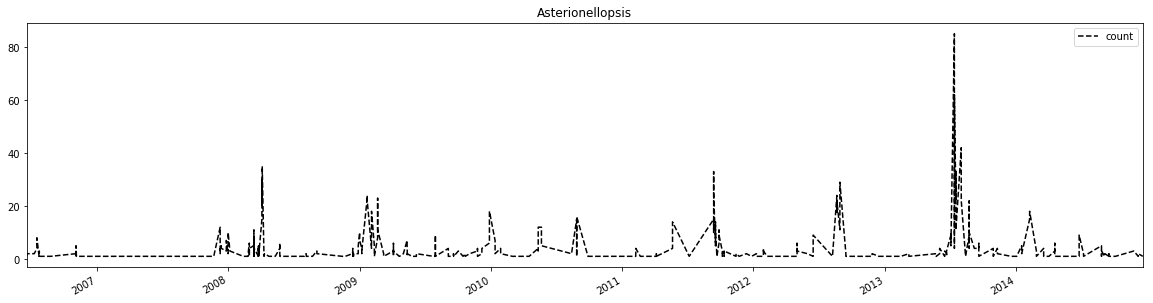

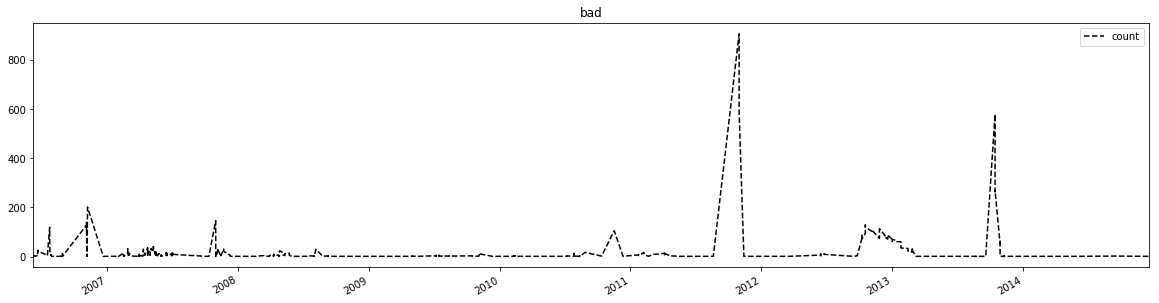

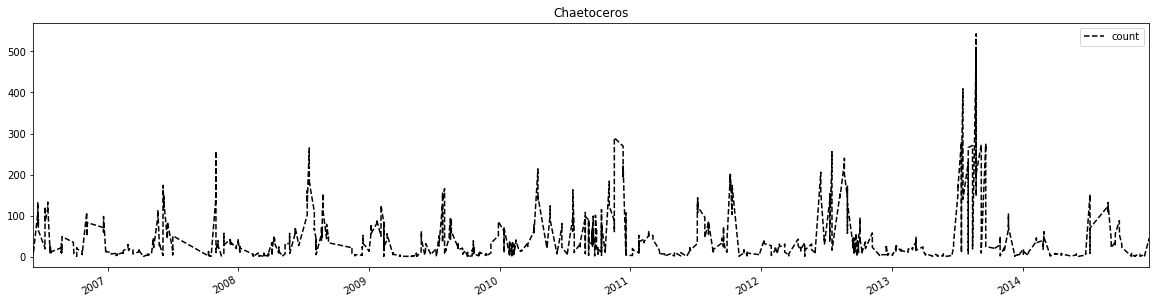

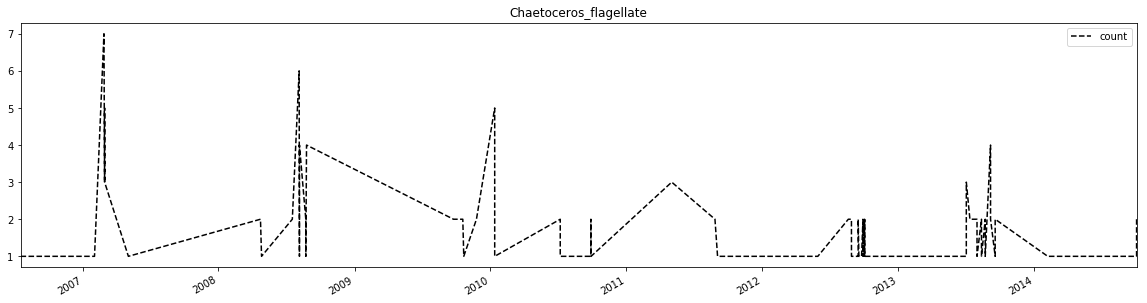

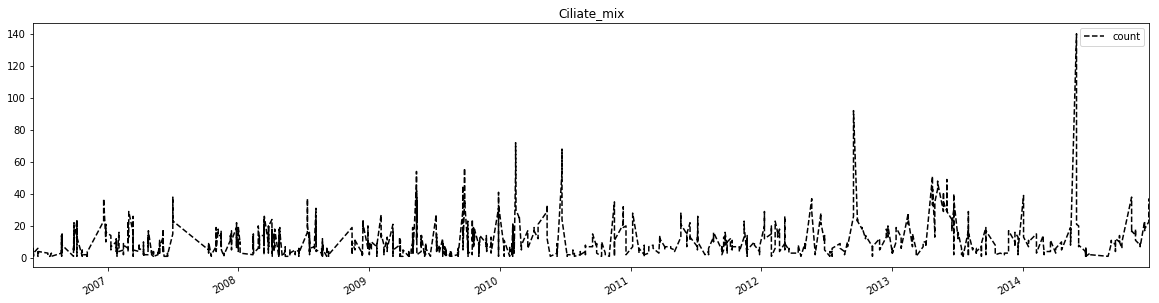

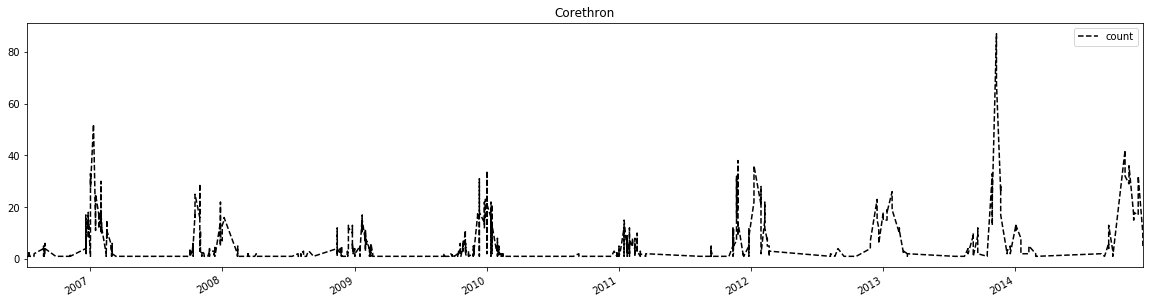

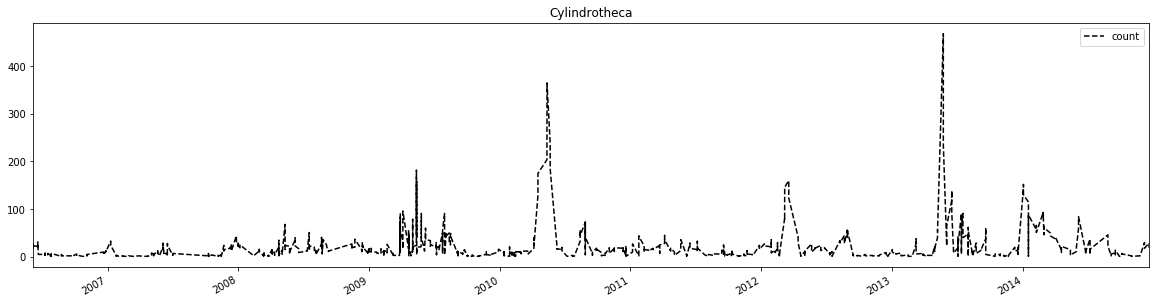

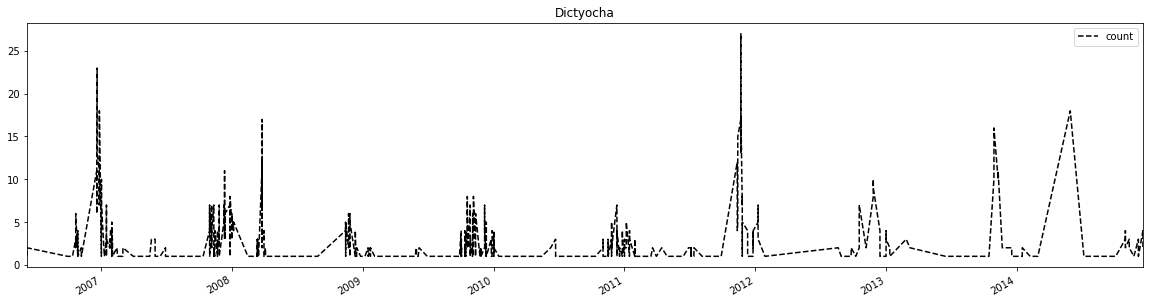

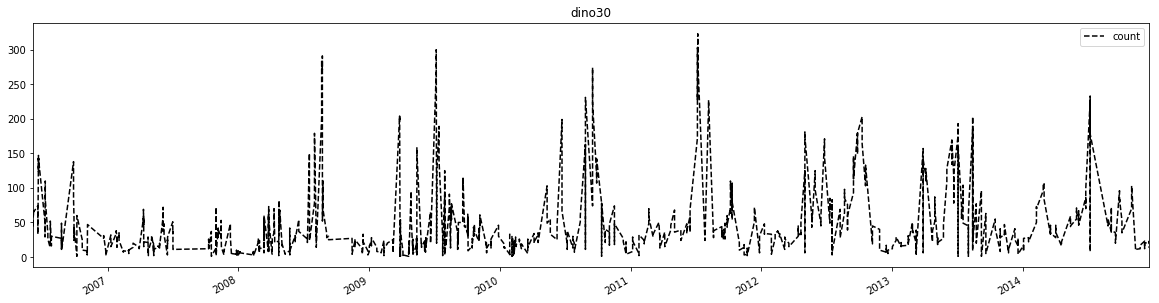

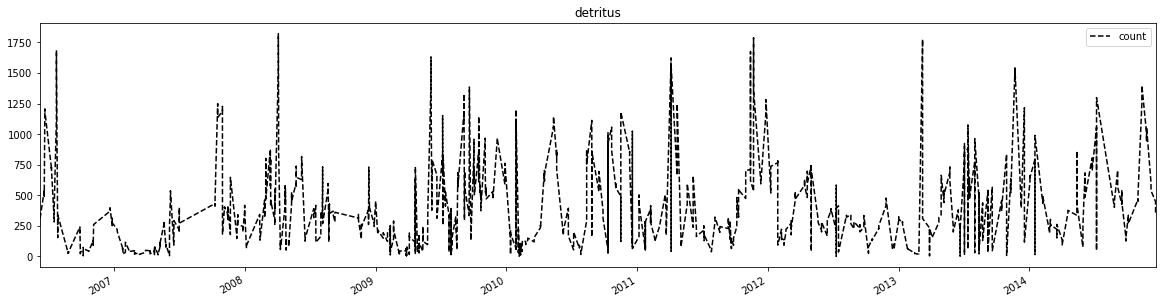

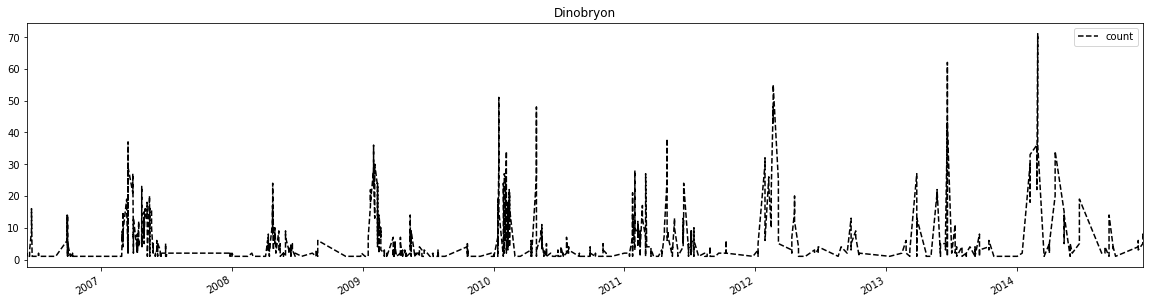

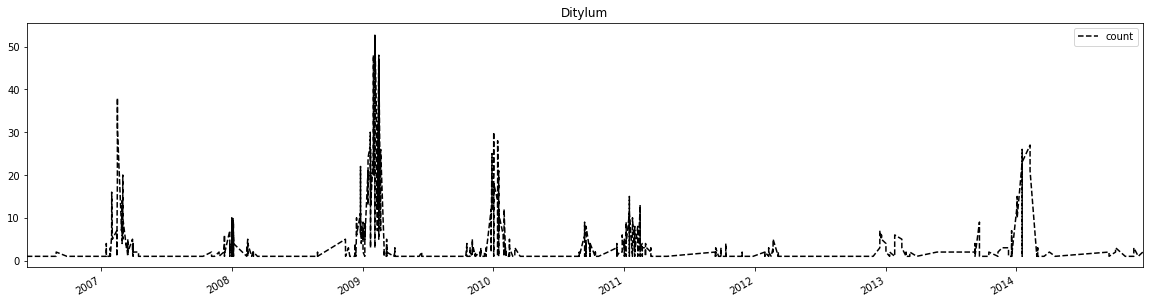

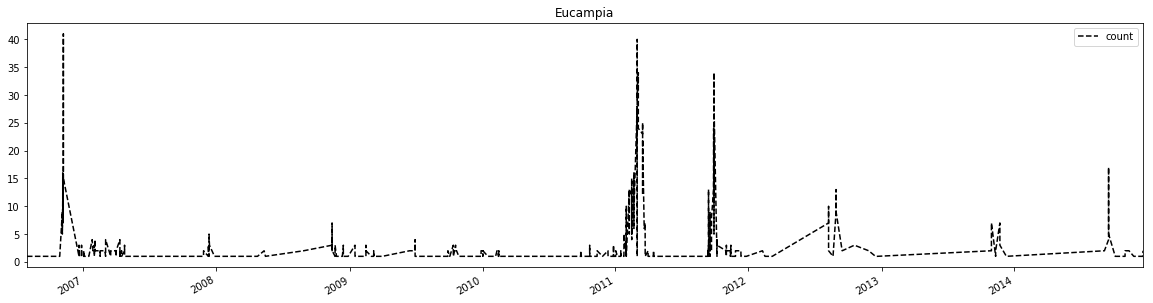

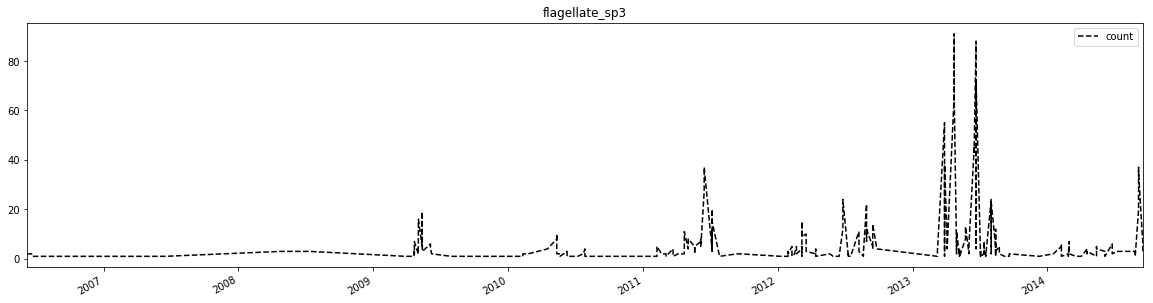

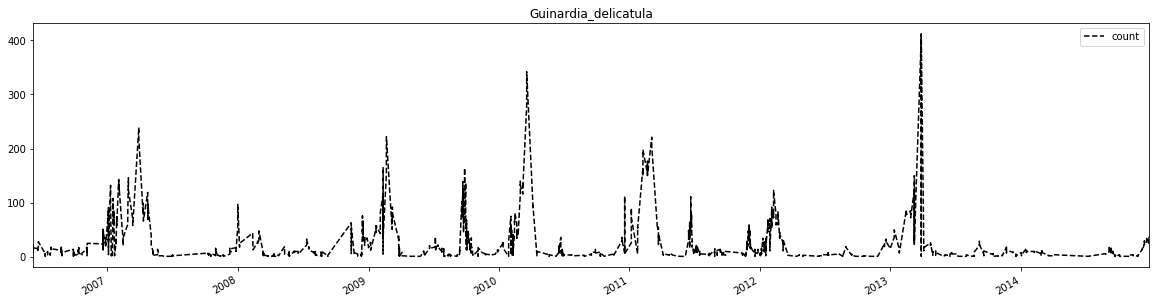

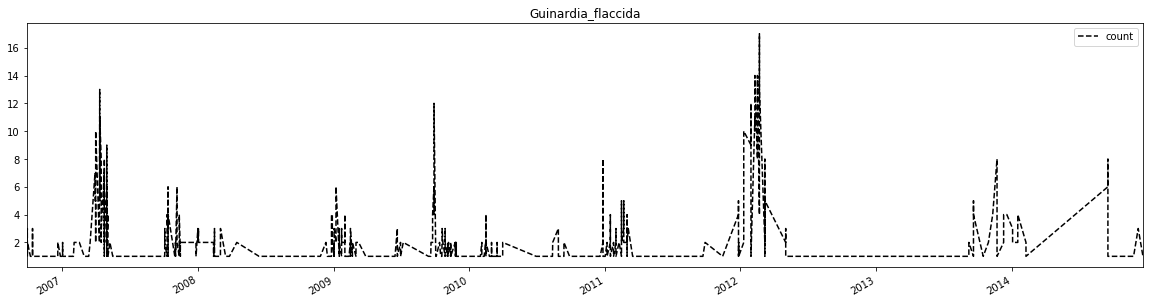

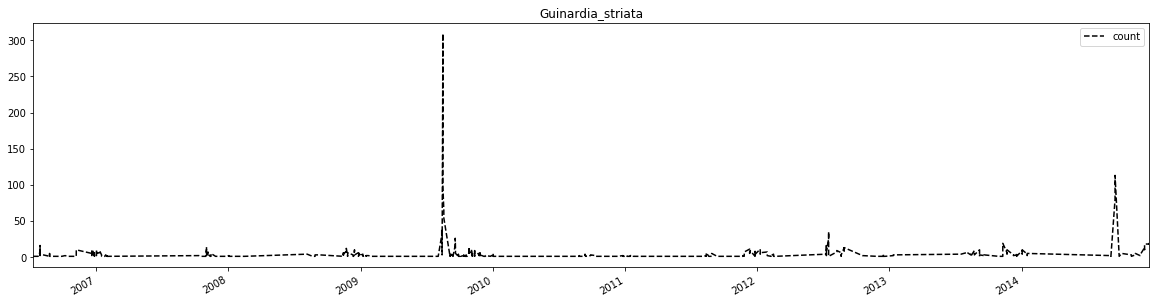

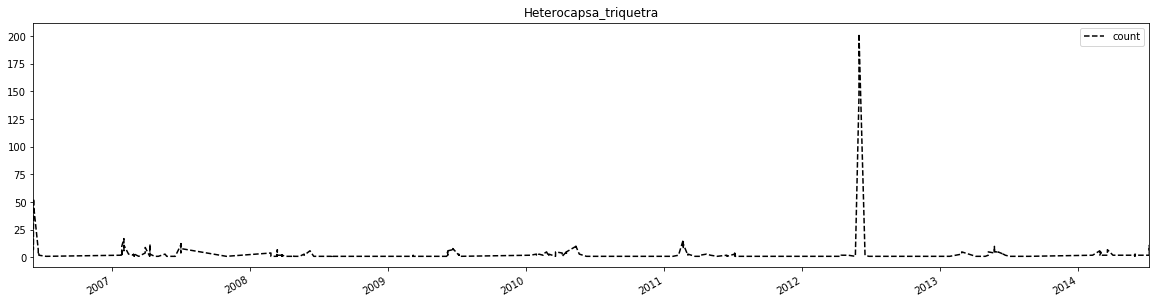

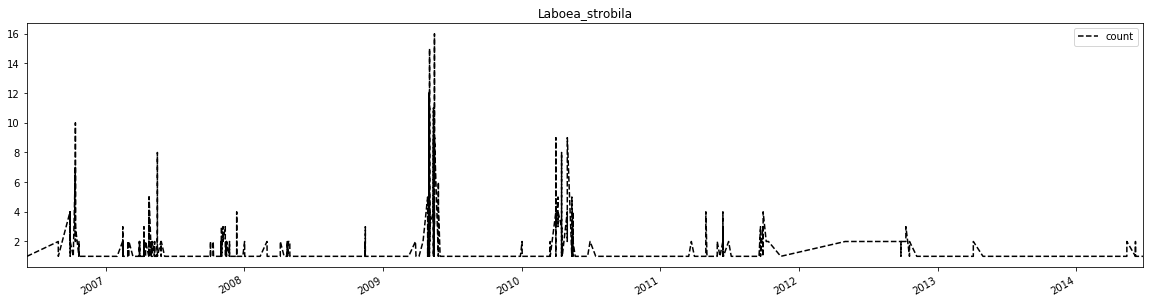

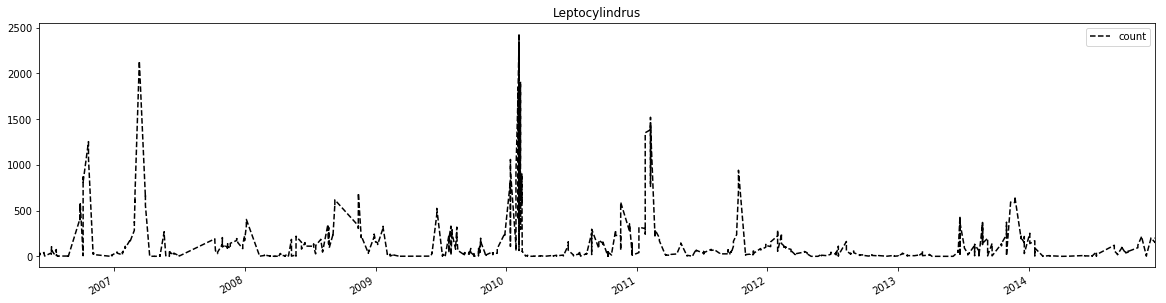

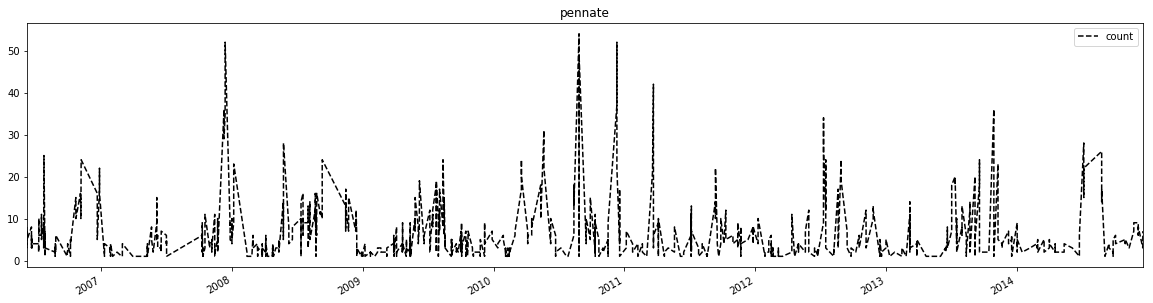

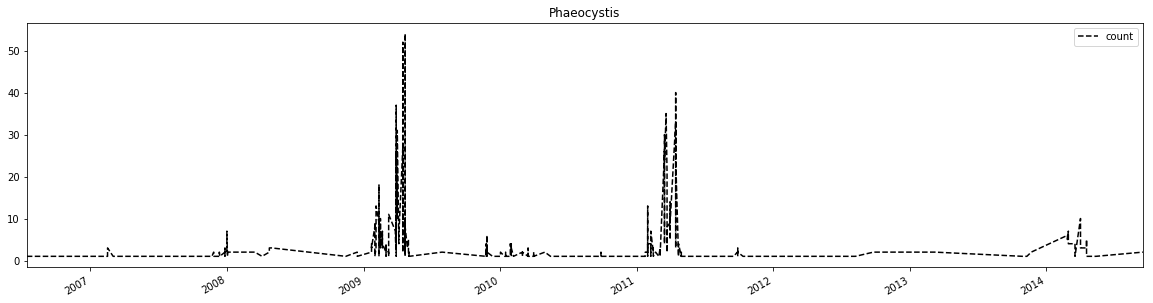

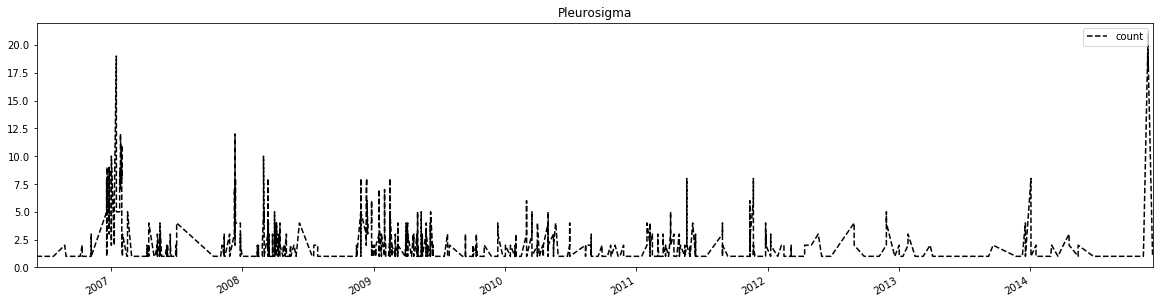

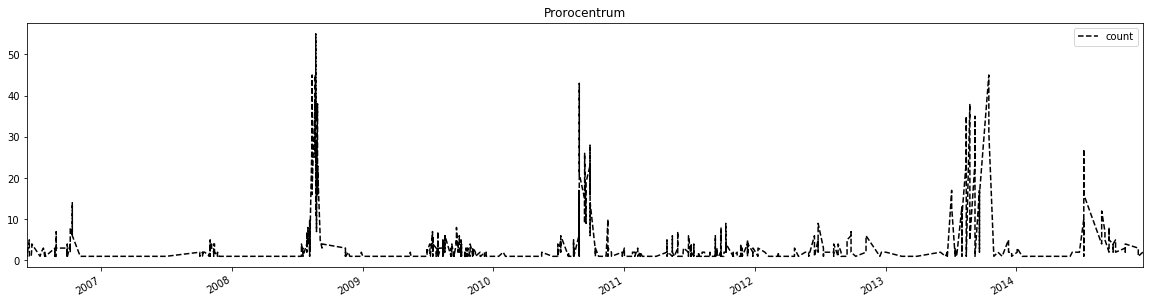

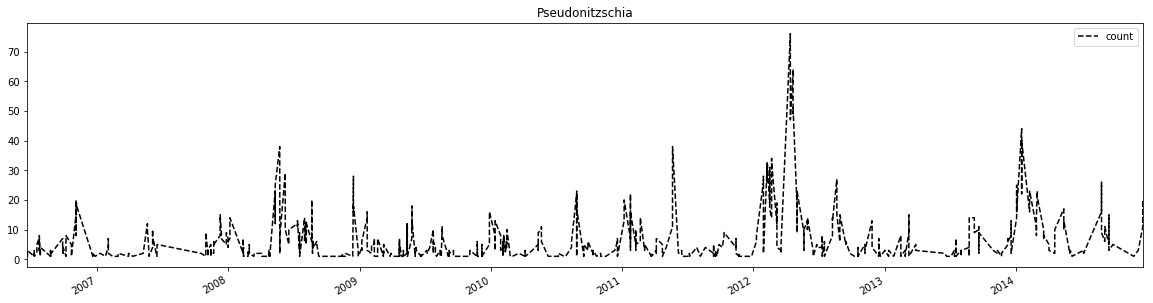

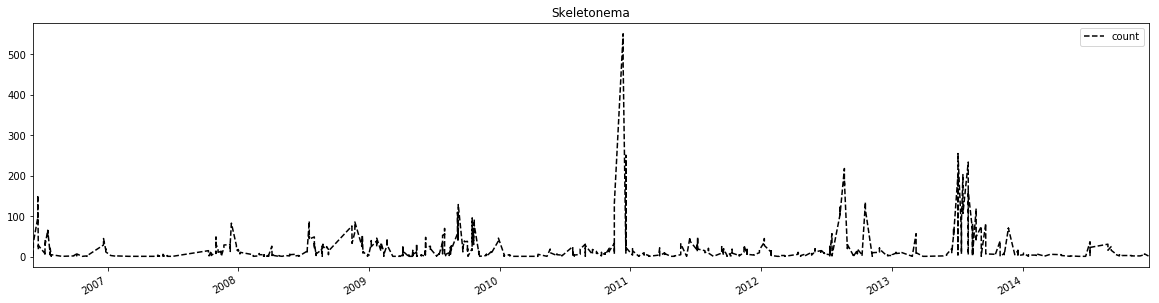

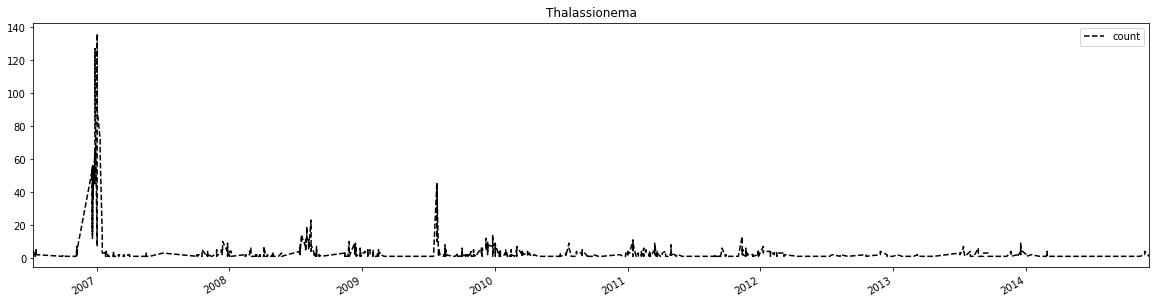

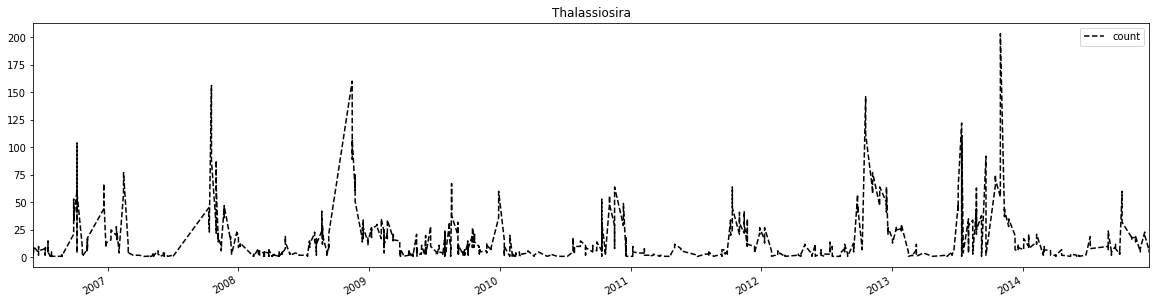

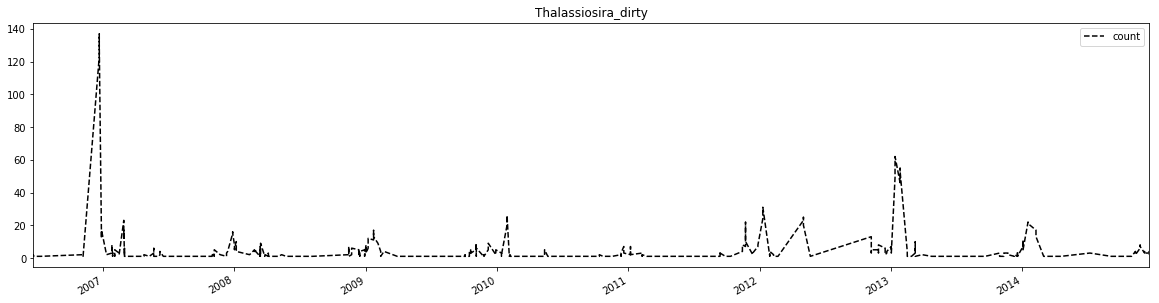

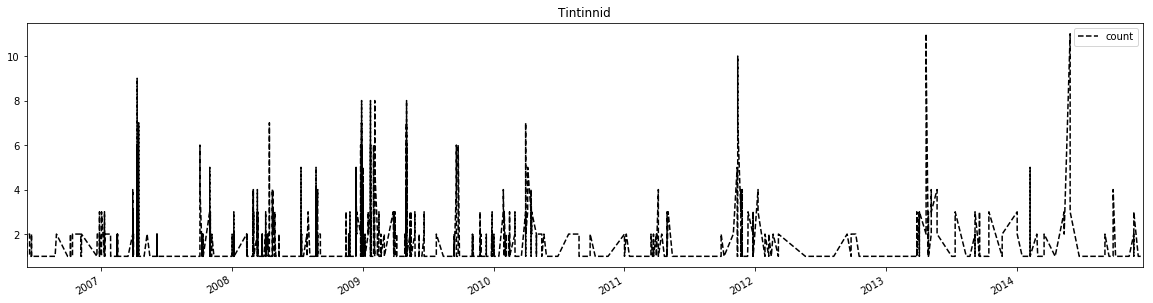

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]
for c_name in classes_30:
    c = y.loc[y['class'] == c_name]
    c.plot(y='order', style='k--')
    plt.title(c_name)
    plt.show()
    

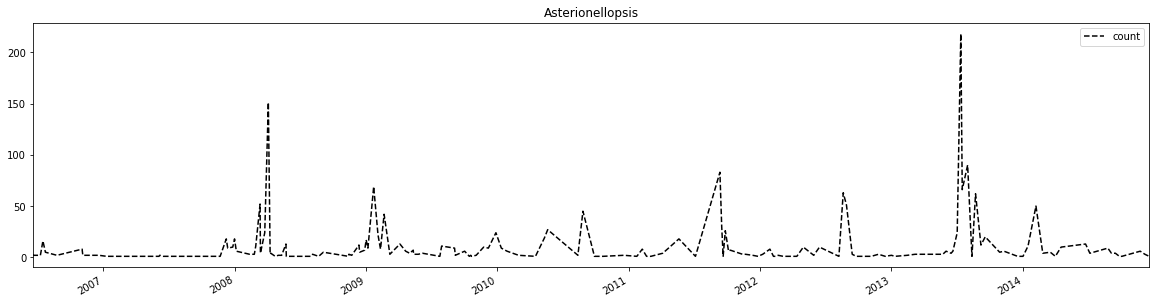

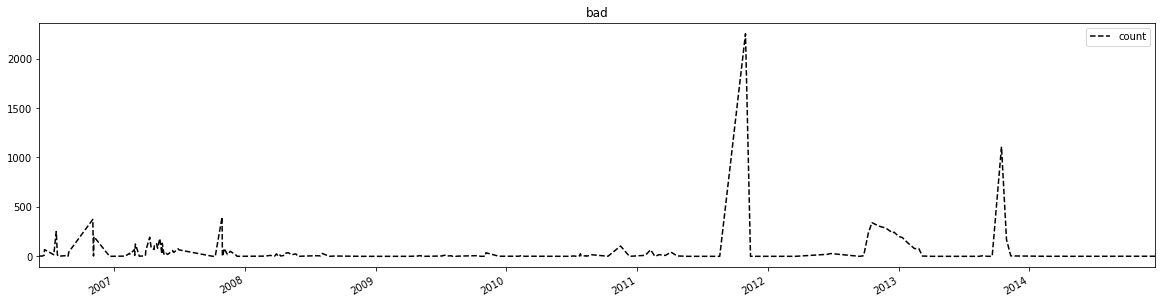

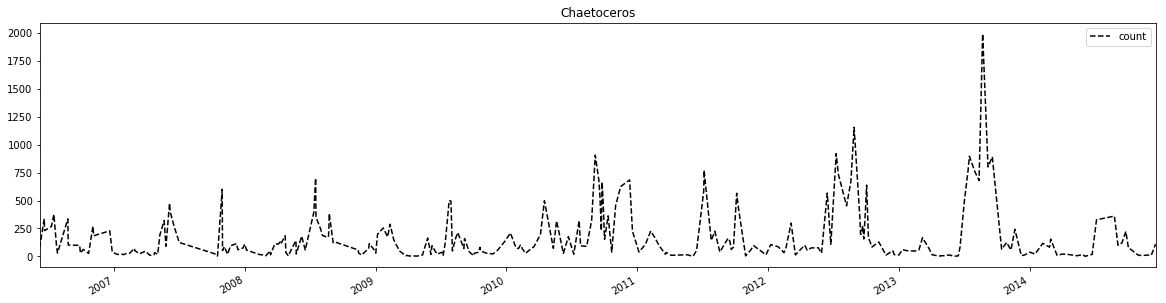

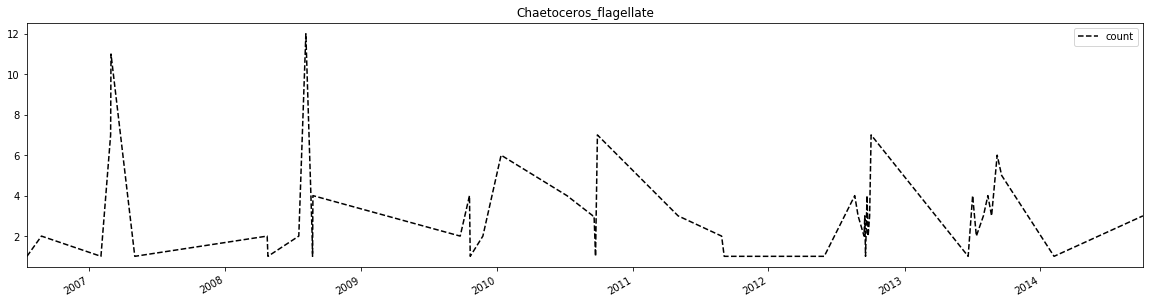

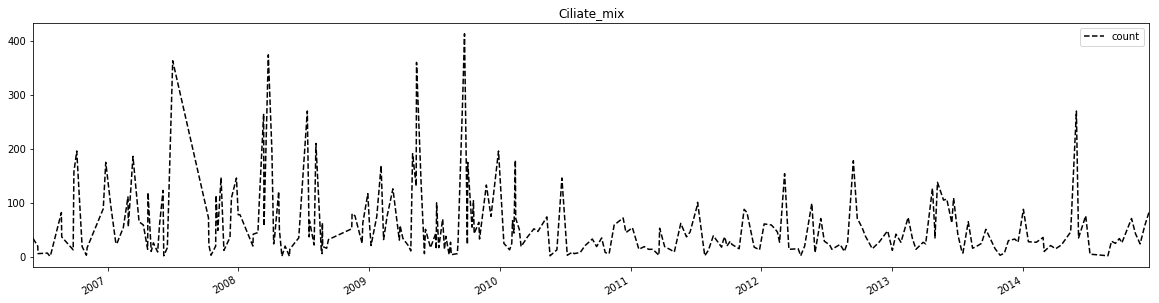

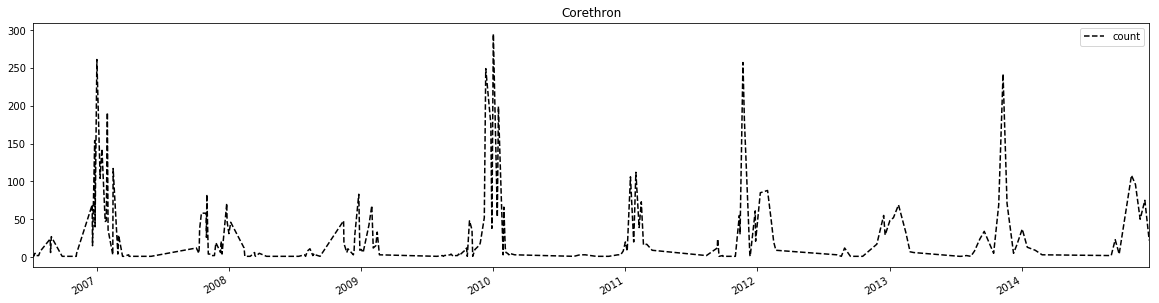

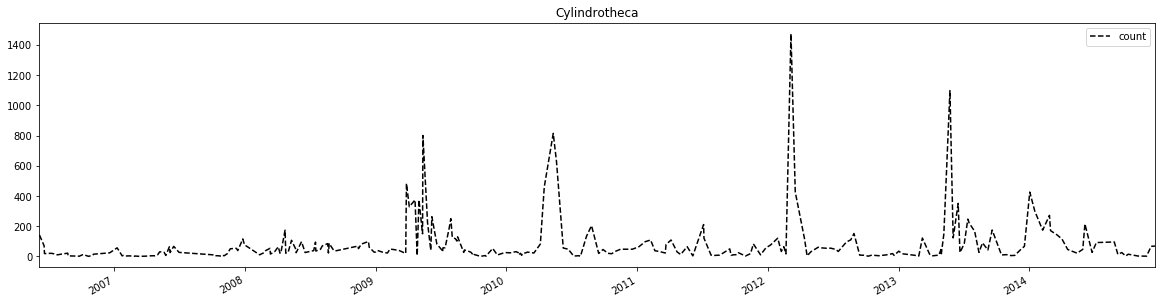

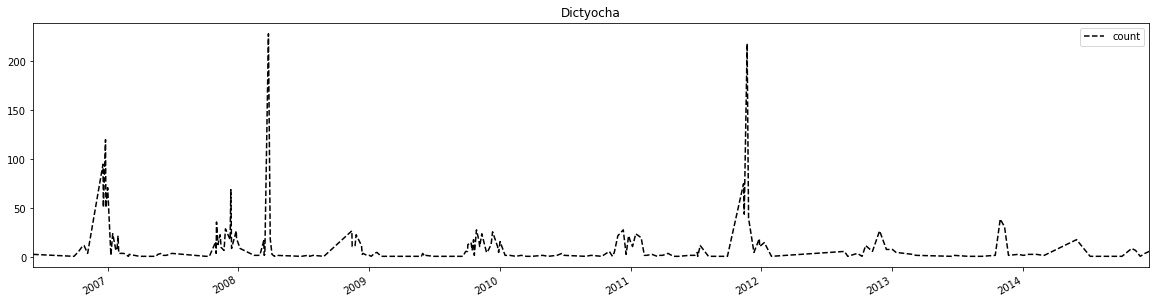

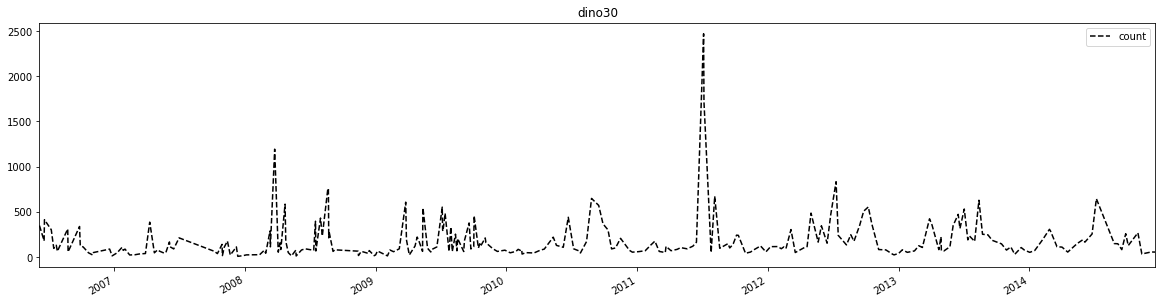

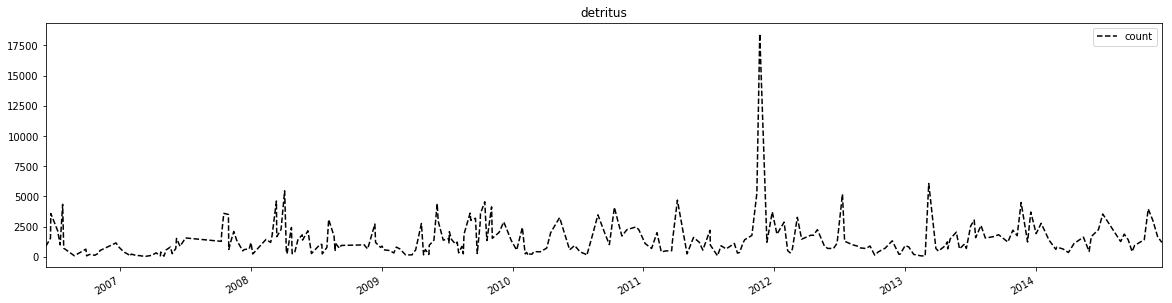

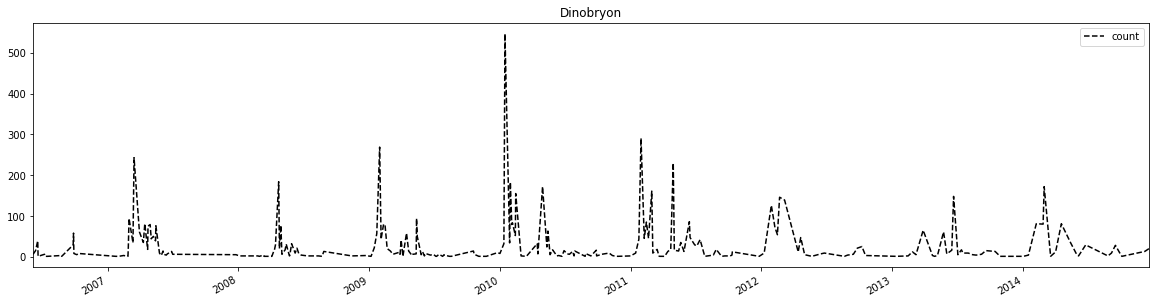

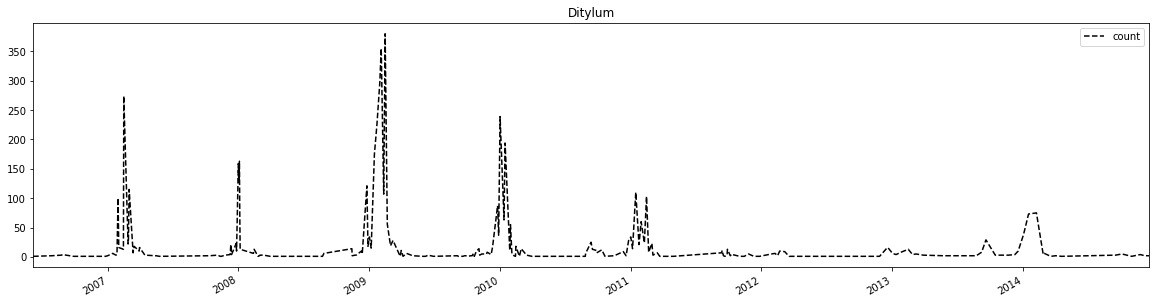

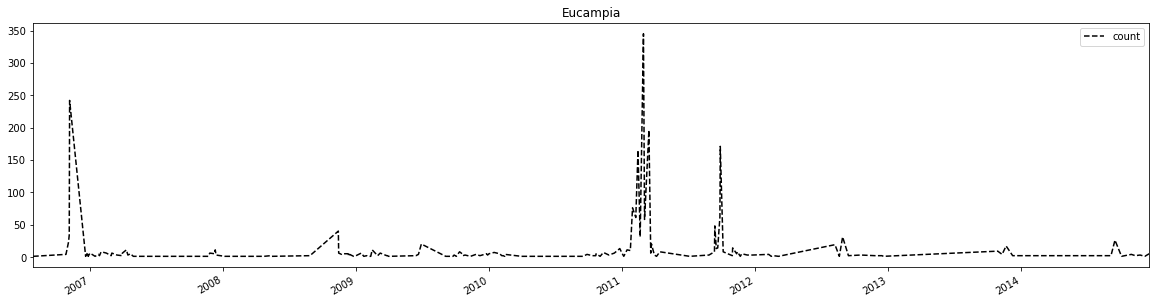

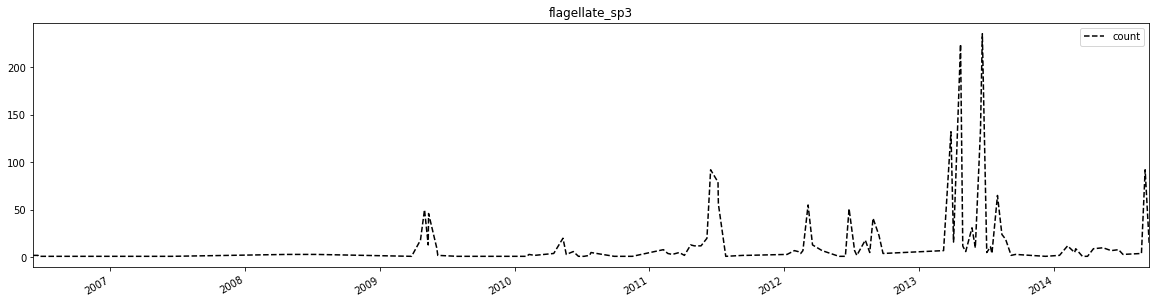

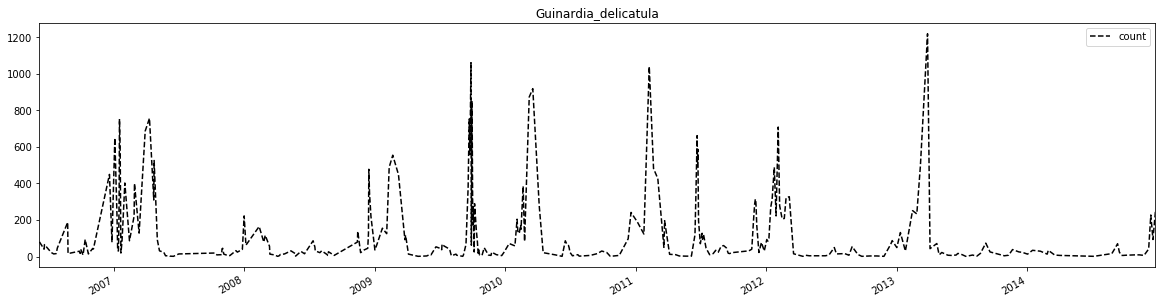

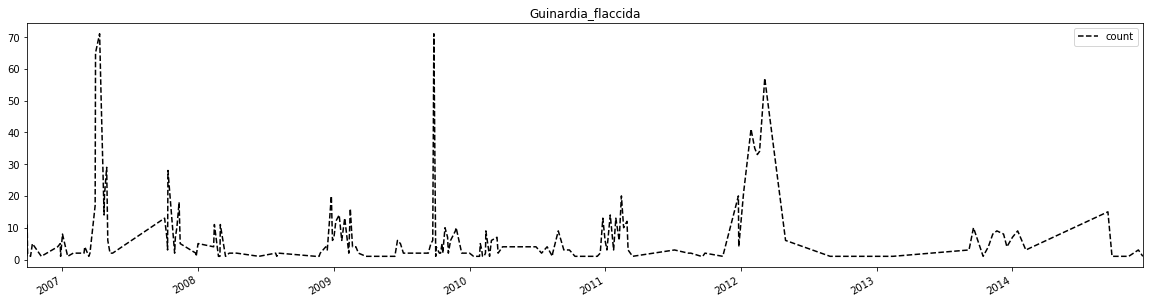

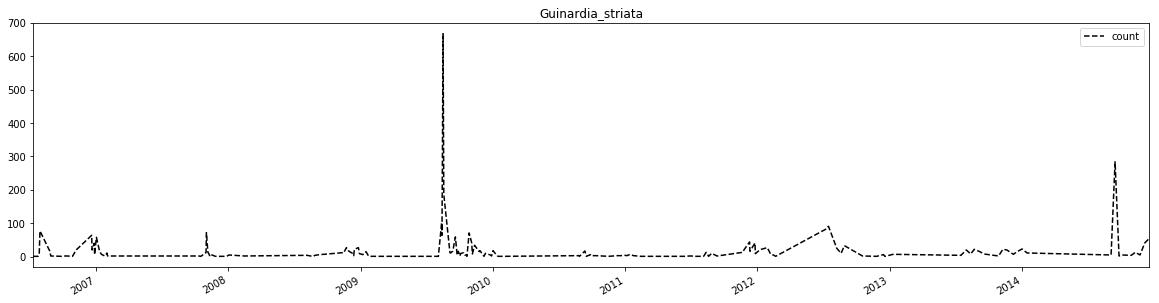

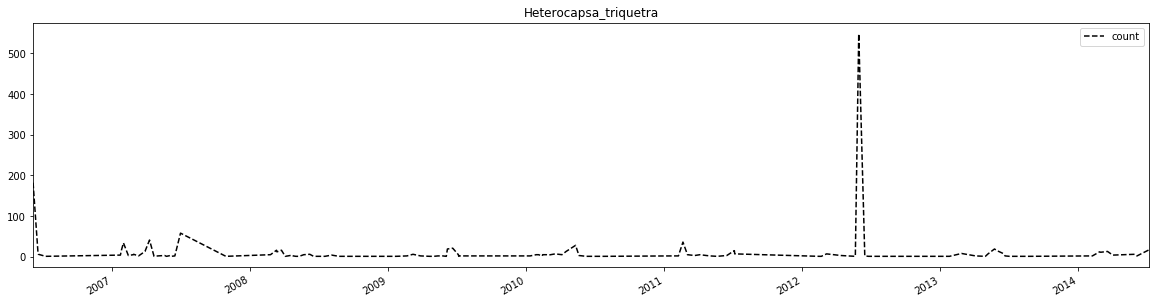

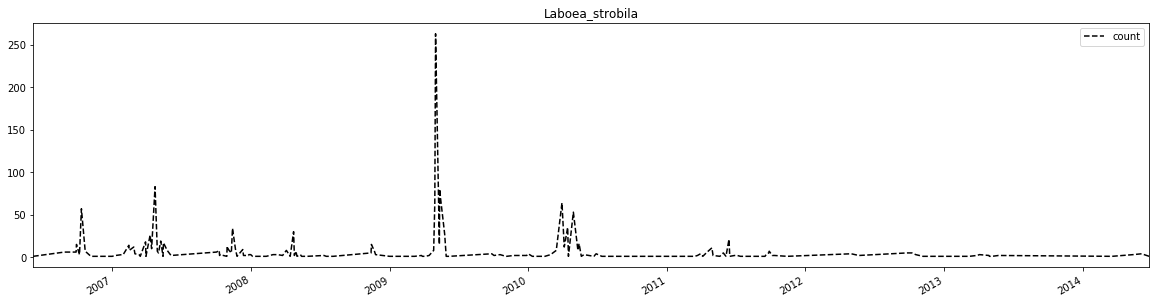

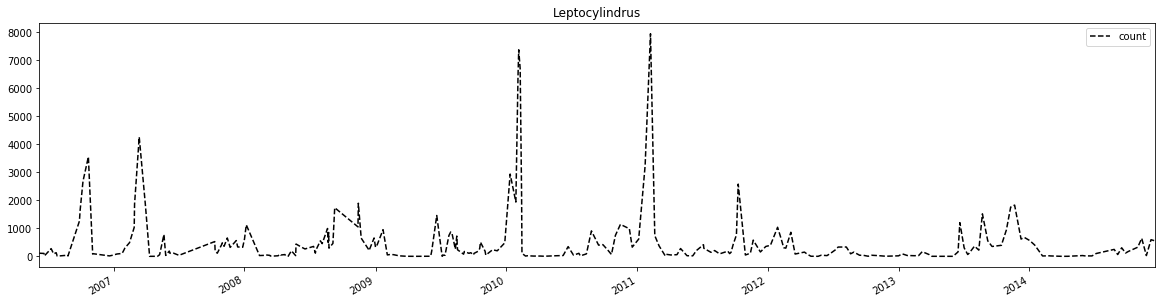

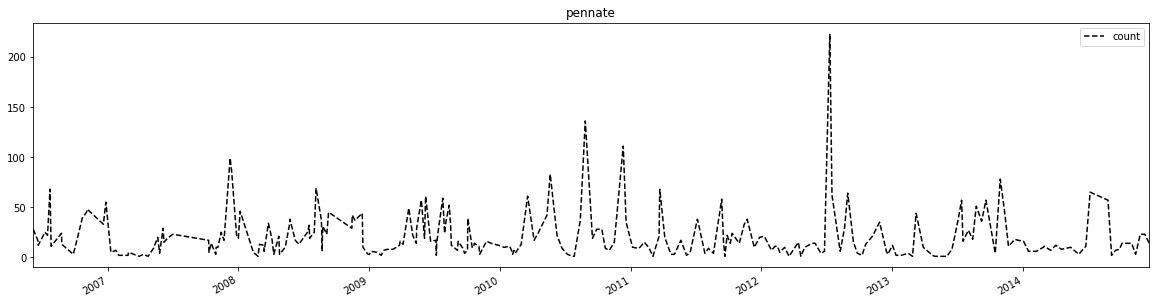

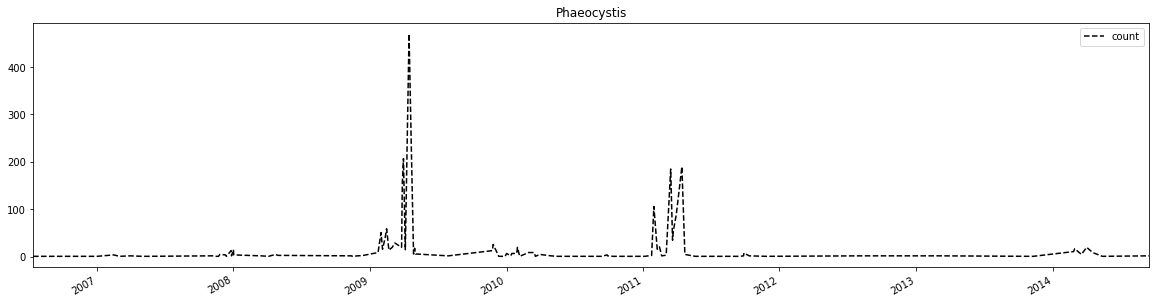

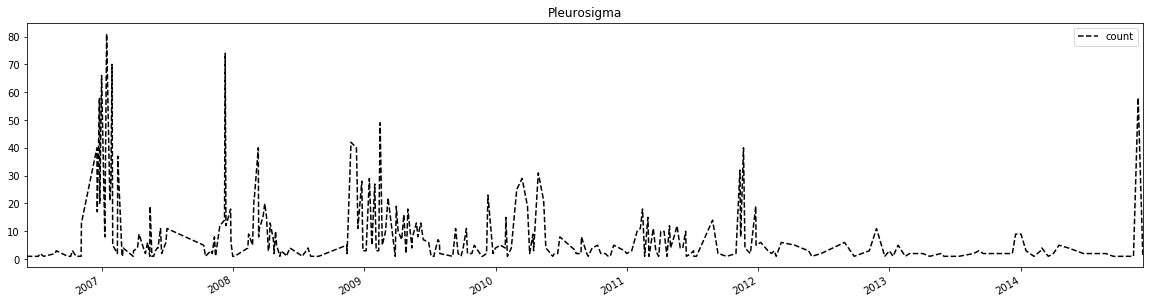

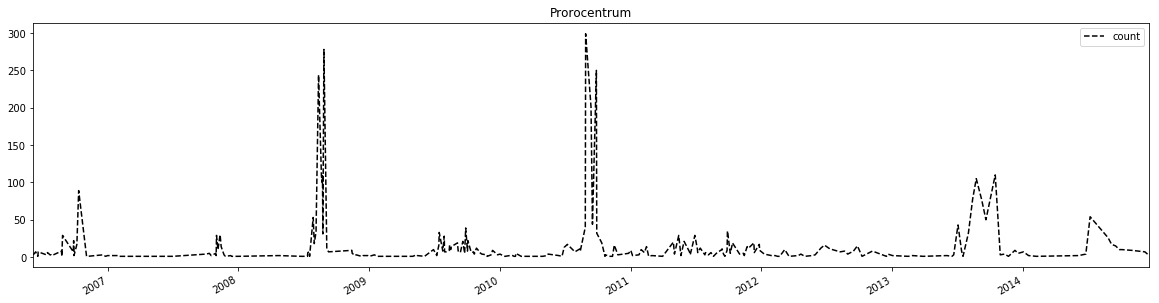

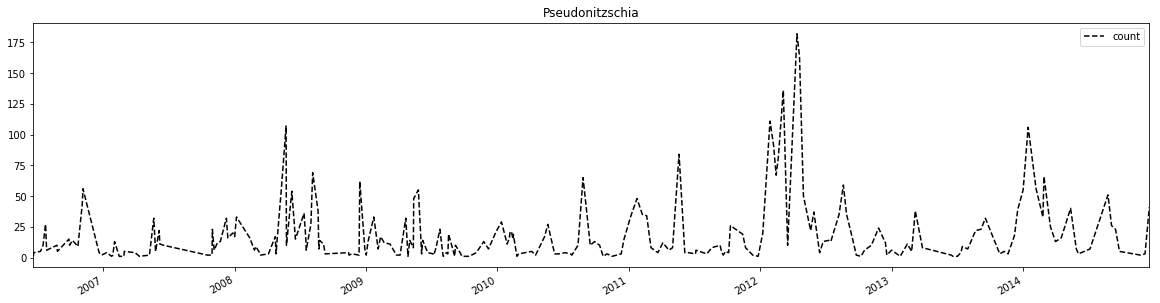

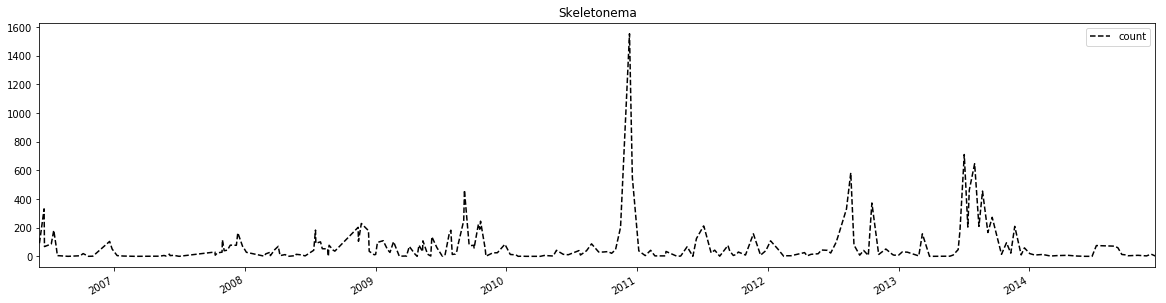

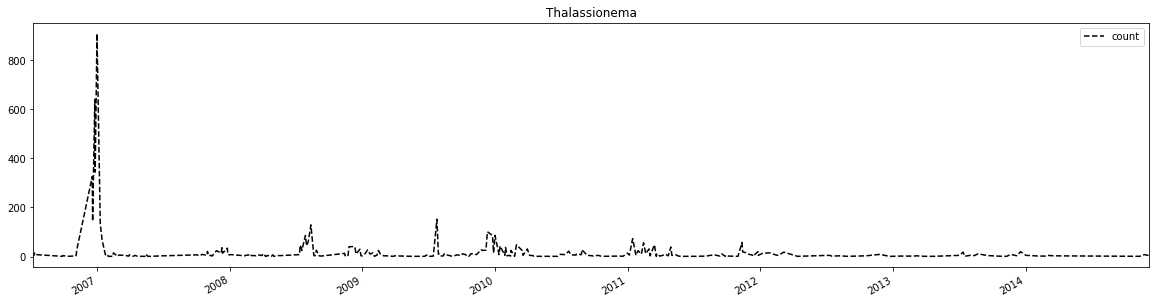

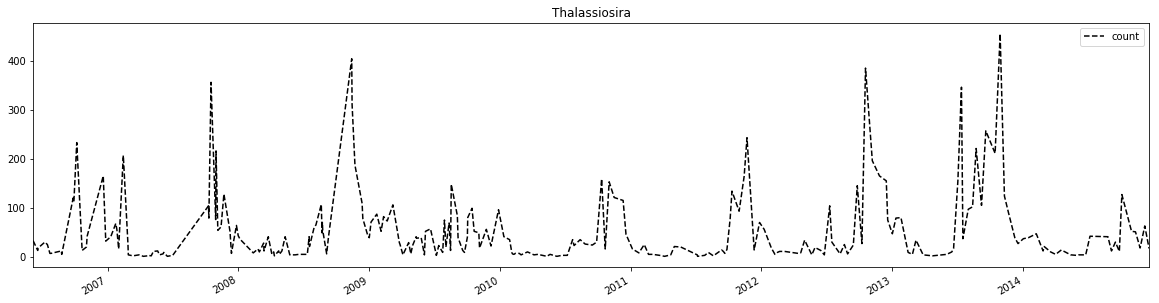

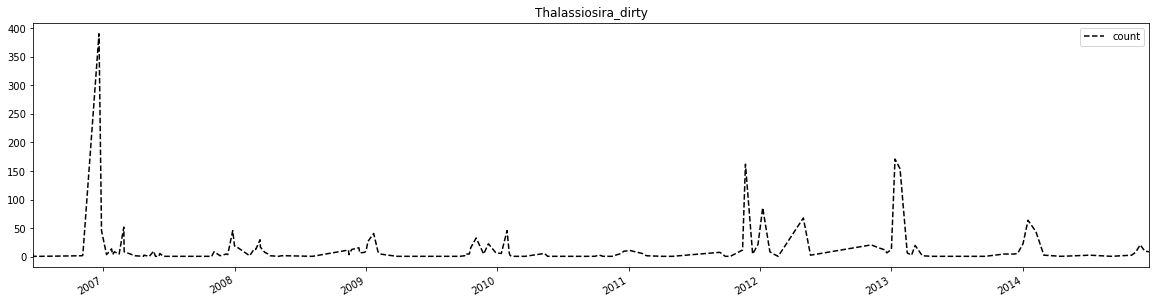

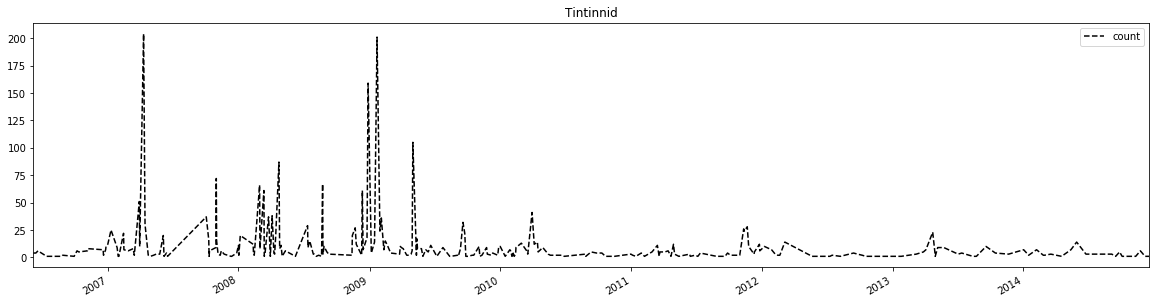

In [20]:
y_day = classes_df.groupby(['class', 'year', 'day']).agg(['count']).reset_index()
y_day.index = pd.to_datetime(y_day.year +'-' +y_day.day, format='%Y-%j')

plt.rcParams['figure.figsize'] = [20, 5]
for c_name in classes_30:
    c = y_day.loc[y_day['class'] == c_name]
    c.plot(y='order', style='k--')
    plt.title(c_name)
    plt.show()

In [23]:
# getting the different IFCB numbers:
ifcbs = classes_df['IFCB'].unique()
for ifcb in ifcbs:
    ind = classes_df['IFCB']==ifcb
    print(ifcb+":", len(classes_df[ind]))

IFCB1: 486380
IFCB5: 291275


In [8]:
# automatically fix the ifcb files
folder = "data/ifcb-raw"
entire_df = None
for f_name in os.listdir(folder):
    f_path = folder+"/"+f_name
    if entire_df is None:
        entire_df = pd.read_csv(f_path)
        entire_df["classified"] = entire_df.loc[:, entire_df.columns != "pid"].idxmax(axis=1)
        entire_df["prob"] = entire_df.max(axis=1)
        to_drop = entire_df.columns.drop(["pid", "classified", "prob"])
        entire_df = entire_df.drop(to_drop, axis=1)
    else:
        temp_df = pd.read_csv(f_path)
        
        # check if temp_df has headers
        if "pid" not in temp_df.columns.values:
            print(f_name)
            print(temp_df[:1])
            print(f_name)
            continue
        # cleaning up df
        temp_df["classified"] = temp_df.select_dtypes(include="number").idxmax(axis=1)
        temp_df["prob"] = entire_df.max(axis=1)
        to_drop = temp_df.columns.drop(["pid", "classified", "prob"])
        temp_df = temp_df.drop(to_drop, axis=1)
        
        # adding dfs
        entire_df, temp_df = entire_df.align(temp_df, join='outer', axis=1)
        entire_df = entire_df.append(temp_df, ignore_index = True) 
        print("new_df shape:", entire_df.shape)

entire_df.to_csv("cleaned_ifcb.csv", index=False, header=True)

new_df shape: (8767, 3)
new_df shape: (11057, 3)
new_df shape: (11800, 3)
new_df shape: (18073, 3)
new_df shape: (18495, 3)
new_df shape: (19062, 3)
new_df shape: (20139, 3)
new_df shape: (24626, 3)


In [11]:
# now checking whether the autoclass (of IFCB) is == annotated version (given in WHOI-P of git repo)
import glob

entire_df = pd.read_csv("cleaned_ifcb.csv")
    
entire_df["annotated"]=0

count = 0
interested_cl_count=0
total = 0
misclassified = 0 
not_exist = 0
for index, row in entire_df.iterrows():
    total += 1
    year = row.pid.split("_")[1]
    data_path = "data/"+year
    if os.path.isdir(data_path+"/"+row.classified):
        interested_cl_count +=1
        file = data_path+"/"+row.classified+"/"+row.pid+".png"
        if os.path.isfile(file):
            #print(file)
            entire_df.set_value(index,'annotated',1)
            count += 1
    else:
        # check for misclassification first
        if row.classified == "mix":
            entire_df.drop(index, inplace=True)
            continue
        
        dirList = glob.glob(data_path+"/**/"+row.pid+".png", recursive=True)
        if len(dirList)>0:
            # missclassified
            plnktn = dirList[0].split("/")[2]
            print(plnktn)
            misclassified += 1
        else:
            not_exist += 1
            entire_df.drop(index, inplace=True)
            
print(count/interested_cl_count)
        
    

/home/czm/anaconda3/envs/redtide/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Chaetoceros_pennate
Chaetoceros
Chaetoceros_pennate
Chaetoceros
Chaetoceros
Chaetoceros_other
Chaetoceros
Chaetoceros
pennates_on_diatoms
Chaetoceros
Chaetoceros
Chaetoceros
Chaetoceros
Chaetoceros_pennate
Chaetoceros
Chaetoceros_didymus_flagellate
Chaetoceros_pennate
dino30
Thalassiosira_dirty
Prorocentrum
Thalassiosira_dirty
Cerataulina
detritus
detritus
dino30
detritus
detritus
detritus
detritus
detritus
detritus
mix_elongated
dino30
Ciliate_mix
detritus
detritus
DactFragCerataul
detritus
detritus
mix_elongated
DactFragCerataul
DactFragCerataul
DactFragCerataul
detritus
mix_elongated
detritus
DactFragCerataul
dino30
Paralia
Guinardia_delicatula
Tintinnid
Cerataulina
detritus
detritus
detritus
mix_elongated
detritus
detritus
DactFragCerataul
DactFragCerataul
dino30
detritus
detritus
Ciliate_mix
detritus
detritus
detritus
DactFragCerataul
detritus
Corethron
DactFragCerataul
Leptocylindrus
detritus
dino30
Thalassiosira
dino30
detritus
Corethron
detritus
detritus
detritus
Leptocylindrus

In [13]:
print(count, interested_cl_count, count/interested_cl_count, count/total)
print(misclassified, total, misclassified/total)
print(not_exist, total, not_exist/total)

1370 7671 0.17859470733932994 0.05563225858848372
269 24626 0.010923414277592788
2924 24626 0.11873629497279298


In [ ]:
a = entire_df[["classified","annotated"]].groupby("classified").mean()
a.plot(kind='bar')

In [ ]:
autoclass_df[["classified","annotated"]].groupby("classified").agg(['sum', 'count'])